<h2> Preliminary - importing necessary libraries (packages) </h2>

In [23]:
import glob

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dateutil import tz

data_directory = '../../RawFiles'
melbourne_tz = tz.gettz('Australia/Melbourne')

sns.set()

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 100)


class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""

    def __init__(self, *args):
        self.args = args

    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)

    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)



<h2> Merging datasets </h2>
(note, loaded data from November 2021 as data is quite big and cannot be loaded at once)

In [24]:
def append_csvs_into_df(file_pattern: str, ignore_index: bool = True, sort: bool = False):
    data_frames = []
    for file in glob.glob(file_pattern):
        print(f'loading: {file}')
        data_frames.append(pd.read_csv(file))
    full_dataset = pd.concat(data_frames, ignore_index=ignore_index, sort=sort)
    return full_dataset


def simple_col_name(x):
    x = x.lower().strip()
    return {'meter_id': 'meter',
            'start_timestamptz_ts': 'time',
            'interval_ts': 'time',
            'active_consumption_kwh': 'consumption',
            'active_generation_kwh': 'generation',
            'ev make': 'make',
            'ev model': 'model',
            "amps_lct": 'amps',
            'ev wall charger installed?': 'charger',
            'how many kms do you usually drive each year? \n(prior to the covid-19 pandemic)': 'drive_kms'
            }.setdefault(x, x)



<li> EV Meters list (those who have EV) </li>

In [25]:
df_with_ev = pd.read_excel(f'{data_directory}/EV_training_meters_list.xlsx').rename(columns=simple_col_name).drop(columns=['kms_group'])
meters_with_ev = df_with_ev['meter'].to_list()
df_with_ev['has_ev'] = 1
df_with_ev.head()


,meter,make,model,charger,drive_kms,has_ev
0,14702,Tesla,Model 3 and Model X,Yes,"Greater than 20,000",1
1,21463,Nissan,Leaf,No,"5,000 to 10,000",1
2,63317,Nissan,Leaf,No,"5,000 to 10,000",1
3,69825,Jaguar,ipace,Yes,"10,000 to 15,000",1
4,98536,Jaguar,ipace,No,"15,000 to 20,000",1


<li> Consumption </li>

In [26]:
# append & rename
df_consumption = append_csvs_into_df(f"{data_directory}/*consumption*nov*21*csv").drop(['Unnamed: 0'], axis=1).rename(
    columns=simple_col_name)
# dates
df_consumption['time'] = pd.to_datetime(df_consumption['time'], infer_datetime_format=True, utc=True).dt.tz_convert(
    melbourne_tz)
df_consumption['total_consumption'] = df_consumption[['consumption', 'generation']].sum(axis=1, skipna=True)
# merge with known EVs
df_consumption = pd.merge(left=df_consumption, right=df_with_ev, on='meter', how='outer')
# needed later
meters_with_no_ev = list(set(df_consumption['meter'].unique().tolist()) - set(meters_with_ev))
# index
df_consumption = df_consumption.set_index(['meter', 'time']).sort_index()
## skip for now
# .drop_duplicates(subset=['meter', 'time'], keep=False).drop('element_uuid', axis=1)\
# .set_index(['time'])\
# .groupby('meter')\
# .resample('5T', closed='right', label='right')\
# .ffill().drop('meter', axis=1)
df_consumption.head()


loading: ../../RawFiles\consumption_training_data_nov21.csv


element_uuid  \
meter time                                                              
396   2021-11-01 11:00:00+11:00  0a6acd53-80f8-4fef-91d0-63b56ff213c5   
      2021-11-01 11:30:00+11:00  0a6acd53-80f8-4fef-91d0-63b56ff213c5   
      2021-11-01 12:00:00+11:00  0a6acd53-80f8-4fef-91d0-63b56ff213c5   
      2021-11-01 12:30:00+11:00  0a6acd53-80f8-4fef-91d0-63b56ff213c5   
      2021-11-01 13:00:00+11:00  0a6acd53-80f8-4fef-91d0-63b56ff213c5   

                                 consumption  generation  total_consumption  \
meter time                                                                    
396   2021-11-01 11:00:00+11:00       0.0437         NaN             0.0437   
      2021-11-01 11:30:00+11:00       0.0750         NaN             0.0750   
      2021-11-01 12:00:00+11:00       0.1187         NaN             0.1187   
      2021-11-01 12:30:00+11:00       0.0562         NaN             0.0562   
      2021-11-01 13:00:00+11:00       0.0437         NaN             0.0437   

                                make model charger drive_kms  has_ev  
meter time                                                            
396   2021-11-01 11:00:00+11:00  NaN   NaN     NaN       NaN     NaN  
      2021-11-01 11:30:00+11:00  NaN   NaN     NaN       NaN     NaN  
      2021-11-01 12:00:00+11:00  NaN   NaN     NaN       NaN     NaN  
      2021-11-01 12:30:00+11:00  NaN   NaN     NaN       NaN     NaN  
      2021-11-01 13:00:00+11:00  NaN   NaN     NaN       NaN     NaN

<li> Power quality </li>

In [27]:
# power quality datasets
# append & rename
df_power_quality = append_csvs_into_df(f"{data_directory}/*power_quality*nov*21*csv").drop(['Unnamed: 0'],
                                                                                           axis=1).rename(
    columns=simple_col_name)
# proper types
df_power_quality['time'] = pd.to_datetime(df_power_quality['time'], infer_datetime_format=True, utc=True).dt.tz_convert(
    melbourne_tz)
obj_columns = df_power_quality.select_dtypes(include='object').columns
df_power_quality[obj_columns] = df_power_quality[obj_columns].astype('category')
# merge with known EVs
df_power_quality = pd.merge(left=df_power_quality, right=df_with_ev, on='meter', how='outer')
# index
df_power_quality = df_power_quality.set_index(['meter', 'time']).sort_index()
df_power_quality.head()


loading: ../../RawFiles\power_quality_training_data_nov21.csv


channel_cd  voltage_lvt      amps  \
meter time                                                          
396   2021-11-01 00:00:00+11:00          a       242.47  0.344000   
      2021-11-01 00:05:00+11:00          a       244.95  0.335175   
      2021-11-01 00:10:00+11:00          a       243.59  0.331522   
      2021-11-01 00:15:00+11:00          a       244.58  0.566290   
      2021-11-01 00:20:00+11:00          a       245.43  0.540289   

                                 power_factor_pf  number_of_phases  \
meter time                                                           
396   2021-11-01 00:00:00+11:00            1.000                 1   
      2021-11-01 00:05:00+11:00           -0.543                 1   
      2021-11-01 00:10:00+11:00           -0.552                 1   
      2021-11-01 00:15:00+11:00           -0.973                 1   
      2021-11-01 00:20:00+11:00           -0.968                 1   

                                overground_or_underground make model charger  \
meter time                                                                     
396   2021-11-01 00:00:00+11:00                        OH  NaN   NaN     NaN   
      2021-11-01 00:05:00+11:00                        OH  NaN   NaN     NaN   
      2021-11-01 00:10:00+11:00                        OH  NaN   NaN     NaN   
      2021-11-01 00:15:00+11:00                        OH  NaN   NaN     NaN   
      2021-11-01 00:20:00+11:00                        OH  NaN   NaN     NaN   

                                drive_kms  has_ev  
meter time                                         
396   2021-11-01 00:00:00+11:00       NaN     NaN  
      2021-11-01 00:05:00+11:00       NaN     NaN  
      2021-11-01 00:10:00+11:00       NaN     NaN  
      2021-11-01 00:15:00+11:00       NaN     NaN  
      2021-11-01 00:20:00+11:00       NaN     NaN

<li> Combining all together </li>
(note: it may take several minutes)

<h2> Graphical Analysis </h2>

<li> Helper functions </li>

In [20]:

def subset_by_meter(meter_id: int, start: str, end: str, cols=None):
    # ensure start and end dates are within dataset range
    cols = cols or ['consumption', 'amps']
    min_date, max_date = df_consumption.reset_index()['time'][[0, len(df_consumption) - 1]]
    start = max(pd.to_datetime(start).tz_localize(melbourne_tz), min_date)
    end = min(pd.to_datetime(end).tz_localize(melbourne_tz), max_date)
    df1 = df_consumption.loc[pd.IndexSlice[meter_id, start:end], :].droplevel('meter')
    df2 = df_power_quality.loc[pd.IndexSlice[meter_id, start:end], :].droplevel('meter')
    return pd.merge(left=df1, right=df2, left_index=True, right_index=True, how='left')[cols]


def plot_subplots_common_x(meter_data, hours_interval: int | None = None) -> None:
    fig, axes = plt.subplots(2, 1, figsize=(30, 12))
    # plot at a time
    for col, ax in zip(meter_data.columns, axes):
        meter_data[col].plot(ax=ax, subplots=True, x_compat=True)
        ax.set_title(col.title())
        ax.set_xlabel("")
        # X axis labels
        date_locator = mdates.DayLocator(interval=1)
        date_form = mdates.DateFormatter("%m-%d")
        ax.xaxis.grid(True, which='major', color='gray')
        ax.xaxis.set_major_locator(date_locator)
        ax.xaxis.set_major_formatter(date_form)
        ax.tick_params(axis='x', which='major', pad=20)
        if hours_interval is not None:
            hour_locator = mdates.HourLocator(interval=hours_interval)
            hour_form = mdates.DateFormatter("%H")
            ax.xaxis.set_minor_locator(hour_locator)
            ax.xaxis.set_minor_formatter(hour_form)

def plot_consumption_amps(meter, start='2021-11-15', end='2021-11-30', hours_interval=12, verbose=True):
    meter_data = subset_by_meter(meter_id=meter, start=start, end=end)
    if verbose:
        meter_info = df_with_ev[df_with_ev['meter'] == meter]
        if not meter_info.empty:
            print(meter_info)
        else:
            print('meter has no EV')
    
    fig = plot_subplots_common_x(meter_data, hours_interval=hours_interval)


<h3> Consumption and current for meters with EV between 15th and 30th November 2021 </h3>

   meter   make                model charger            drive_kms  has_ev
0  14702  Tesla  Model 3 and Model X     Yes  Greater than 20,000       1


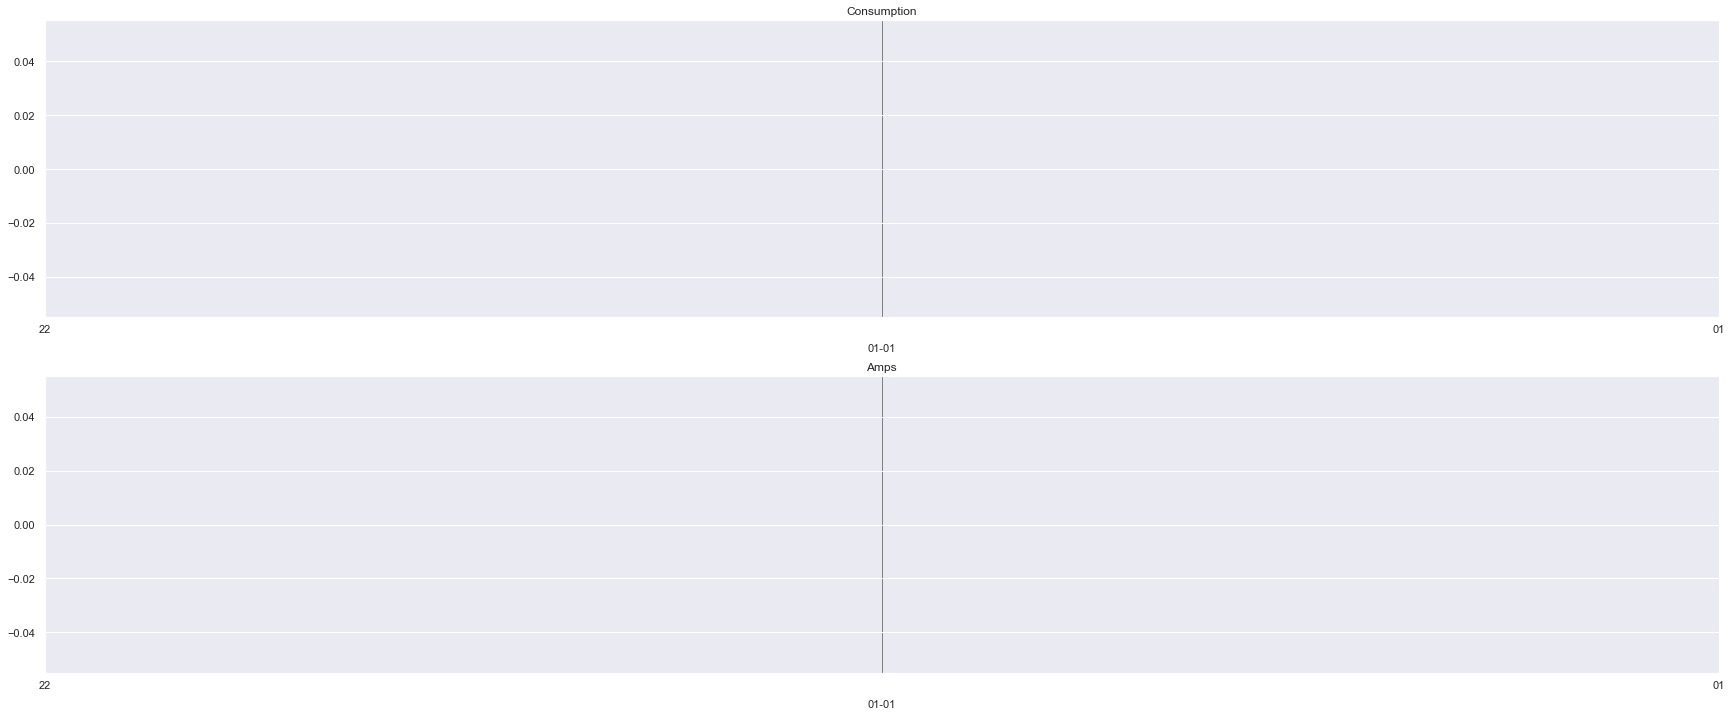

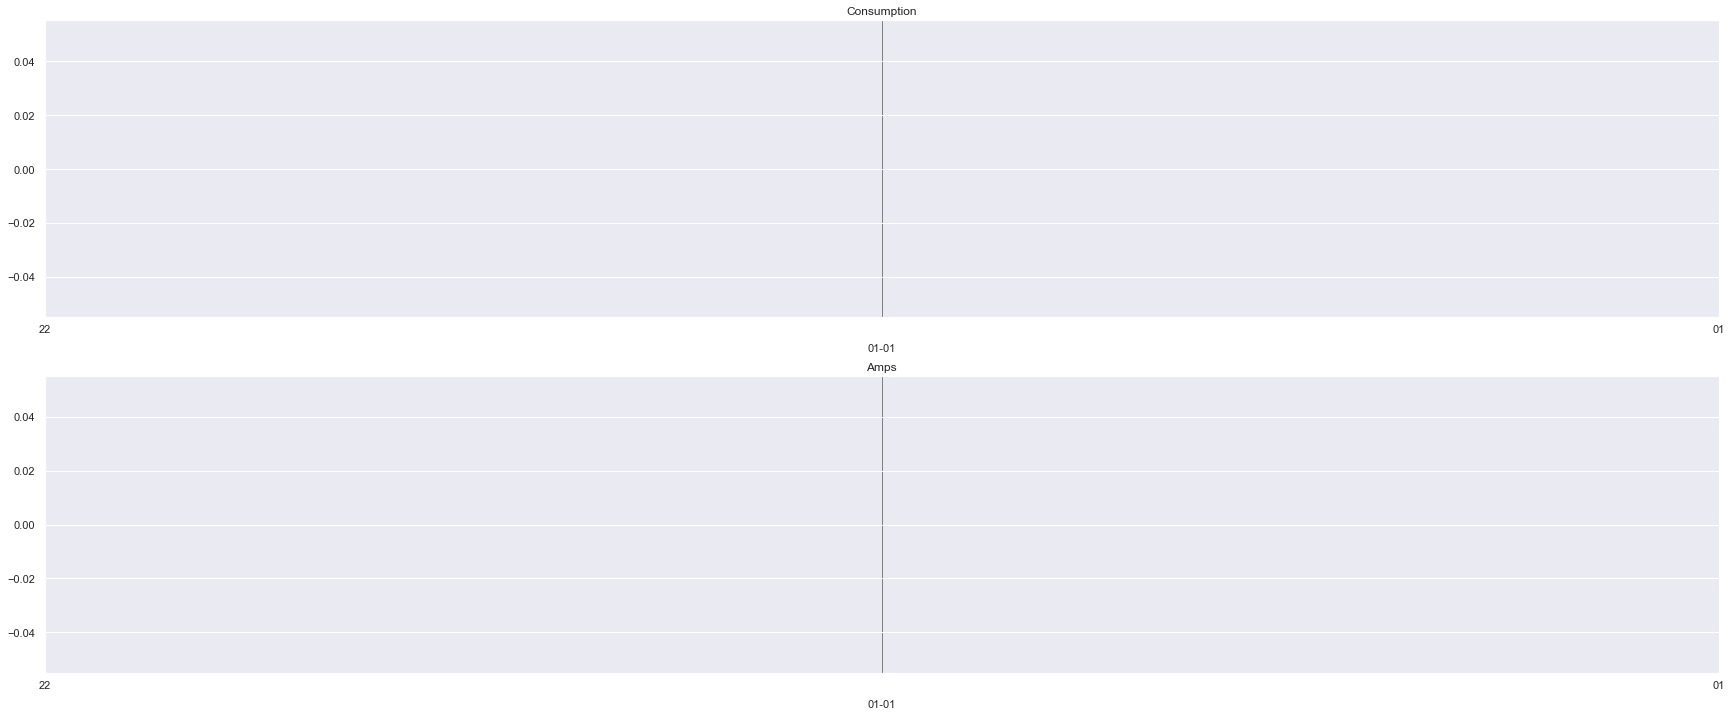

In [21]:
plot_consumption_amps(meter=meters_with_ev[0])
## example of customized plot
plot_consumption_amps(meter=meters_with_ev[0], start='2021-11-15', end='2021-11-17', hours_interval=6, verbose=False)

   meter    make model charger        drive_kms  has_ev
1  21463  Nissan  Leaf      No  5,000 to 10,000       1


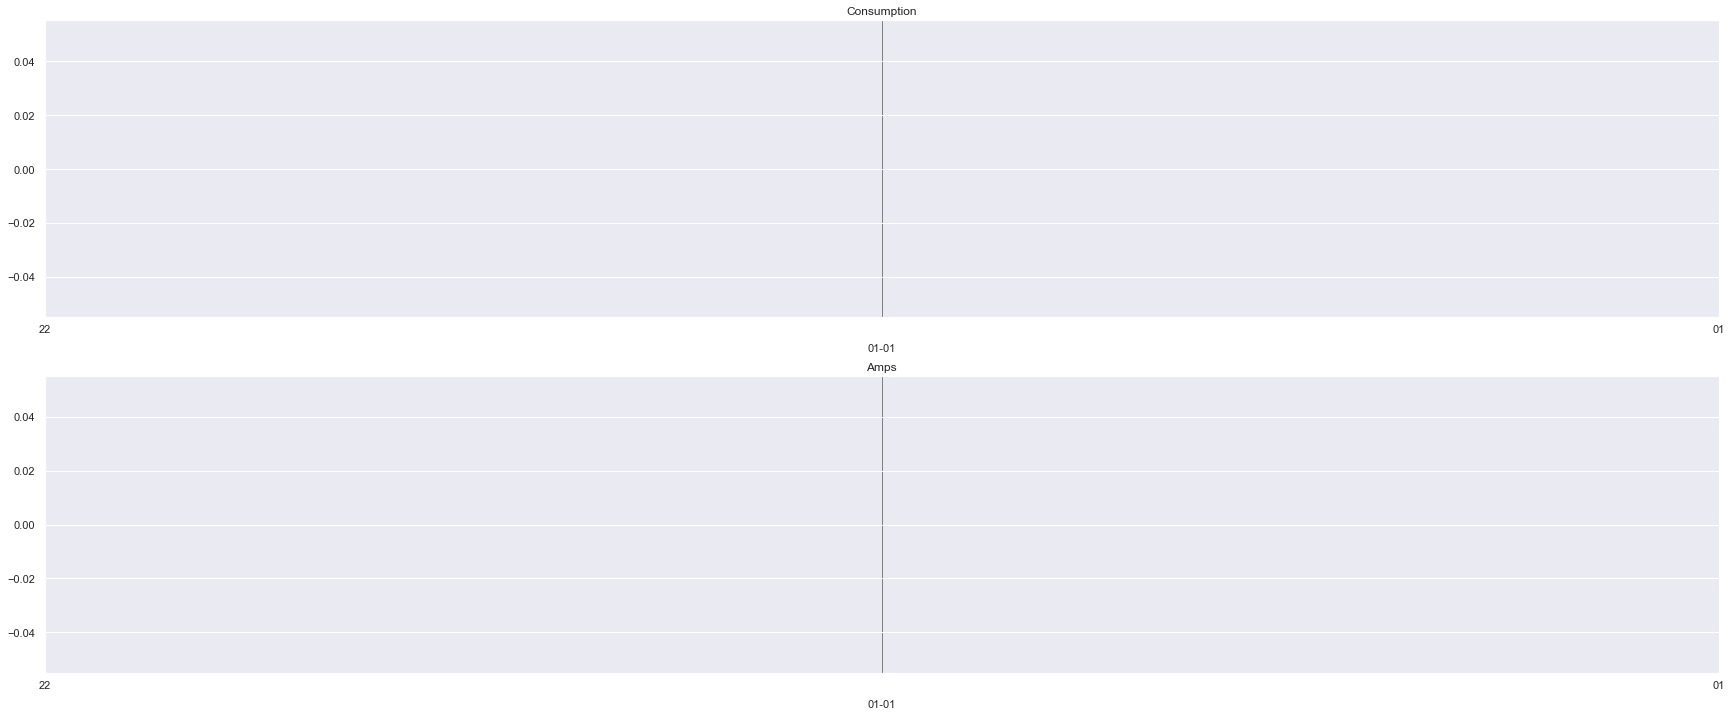

In [22]:
plot_consumption_amps(meter=meters_with_ev[1])

In [ ]:
plot_consumption_amps(meters_with_ev[2])
plot_consumption_amps(meters_with_ev[2], start='2021-11-23', end='2021-11-26')

In [ ]:

plot_consumption_amps(meters_with_ev[3])

In [ ]:
plot_consumption_amps(meters_with_ev[4])

In [ ]:
plot_consumption_amps(meters_with_ev[5])

In [ ]:
plot_consumption_amps(meters_with_ev[6])

In [ ]:
plot_consumption_amps(meters_with_ev[7])

In [ ]:
plot_consumption_amps(meters_with_ev[8])

In [ ]:
plot_consumption_amps(meters_with_ev[9])

In [ ]:
plot_consumption_amps(meters_with_ev[10])

In [ ]:
plot_consumption_amps(meters_with_ev[11])

In [ ]:
plot_consumption_amps(meters_with_ev[12])

In [ ]:
plot_consumption_amps(meters_with_ev[13])

In [ ]:
plot_consumption_amps(meters_with_ev[14])

In [ ]:
plot_consumption_amps(meters_with_ev[15])


<h3> No EV meters for same period as above </h3>

In [ ]:
plot_consumption_amps(meters_with_no_ev[0])
plot_consumption_amps(meters_with_no_ev[0], start='2021-11-15', end='2021-11-19')

In [ ]:
plot_consumption_amps(meters_with_no_ev[1])

In [ ]:
plot_consumption_amps(meters_with_no_ev[2])

In [ ]:
plot_consumption_amps(meters_with_no_ev[3])

In [ ]:
plot_consumption_amps(meters_with_no_ev[4])

In [ ]:
plot_consumption_amps(meters_with_no_ev[5])

In [ ]:

plot_consumption_amps(meters_with_no_ev[7])

In [ ]:
plot_consumption_amps(meters_with_no_ev[8])

In [ ]:
plot_consumption_amps(meters_with_no_ev[9])


In [ ]:
plot_consumption_amps(meters_with_no_ev[10])

In [ ]:
plot_consumption_amps(meters_with_no_ev[11])

In [ ]:
plot_consumption_amps(meters_with_no_ev[12])

In [ ]:
plot_consumption_amps(meters_with_no_ev[13])
plot_consumption_amps(meters_with_no_ev[13], start='2021-11-20', end='2021-11-24', hours_interval=3)

In [ ]:
plot_consumption_amps(meters_with_no_ev[14])

In [ ]:
plot_consumption_amps(meters_with_no_ev[15])

<h3> Ignore beyond here for now </h3>

In [ ]:
# def plot_series_with_resamples(df, series, meter_id, start, end):
#     data = df[['consumption', 'generation']].loc[(meter_id, start):(
#         meter_id, end), series].droplevel(0)
#     fig, ax = plt.subplots(figsize=(20, 8))
#     ax.plot(data, marker='.', linestyle='-', linewidth=0.5, label='raw')
#     ax.plot(data.resample('H').mean(), marker='o', linestyle='-',
#             markersize=8, label='Hourly Mean Resample')
#     ax.set_ylabel('consumption')
#     ax.legend()


# plot_series_with_resamples(df_full,
#                            'consumption',
#                            717681, '2021-11-03', '2021-11-09')


<h2> Separate datasets (consumption and power quality) </h2>

In [ ]:
df_consumption['has_ev'] = np.where(df_consumption['has_ev'].isna(), 0, 1)
# for col in ['year', 'month', 'day', 'hour', 'minute']:
#     df_consumption[col] = getattr(pd.DatetimeIndex(df_consumption['time']), col)
df_consumption_analysis = df_consumption.drop(
    columns=['generation', 'ev_make', 'ev_model', 'wallcharger', 'annual_km', 'annual_km_group',
             'year', 'month', 'day', 'hour', 'minute'])
df_consumption_analysis['identifier'] = df_consumption_analysis['meter'].astype('str') + df_consumption_analysis[
    'element_uuid']
df_consumption_analysis = df_consumption_analysis.drop(columns=['meter', 'element_uuid']).set_index(
    ['identifier', 'time'])
df_consumption_analysis.head()

In [ ]:
import statsmodels.api as sm
from linearmodels import PanelOLS

exog = sm.tools.add_constant(df_consumption_analysis['consumption'])
endog = df_consumption_analysis['has_ev']
# fixed effects model
model_fe = PanelOLS(endog, exog, entity_effects=True)
fe_res = model_fe.fit()
print(fe_res)

In [ ]:
df_power_quality['has_ev'] = np.where(df_power_quality['has_ev'].isna(), 0, 1)
# for col in ['year', 'month', 'day', 'hour', 'minute']:
#     df_power_quality[col] = getattr(pd.DatetimeIndex(df_power_quality['time']), col)
df_power_quality.drop(
    columns=['overground_or_underground', 'ev_make', 'ev_model', 'wallcharger', 'annual_km', 'annual_km_group'],
    inplace=True)
df_power_quality['identifier'] = df_power_quality['meter'].astype('str') + df_power_quality['channel_cd']
df_power_quality.drop(columns=['meter', 'channel_cs'], inpalce=True)
df_power_quality.set_index(['identifier', 'time'], inplace=True)
df_power_quality.head()

In [ ]:
# import statsmodels.api as sm
# from linearmodels import PanelOLS

# exog = sm.tools.add_constant(df_power_quality['amps'])
# exog = sm.tools.add_constant(df_power_quality['voltage_lvt'])
# exog = sm.tools.add_constant(df_power_quality['power_factor_pf'])
# exog = sm.tools.add_constant(df_power_quality['number_of_phases'])
# endog = df_consumption_analysis['has_ev']
# # fixed effects model
# model_fe = PanelOLS(endog, exog, entity_effects=True)
# fe_res = model_fe.fit()
# print(fe_res)